<a href="https://colab.research.google.com/github/sudevansujit/Movie_Sentiment_Analysis/blob/master/Movie_Sentiment_Deep_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':'1asZyLVRZ3QjWG4Pek-dAYYl9Kq9XZn3n'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Cleaned_Movie_Review.csv')

In [6]:
import pandas as pd
import numpy as np

data = pd.read_csv('Cleaned_Movie_Review.csv', index_col = 'Unnamed: 0')
data.head()

,review,sentiment,new_review
0,one of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode ho...
1,a wonderful little production the filming tech...,1,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,basically there s a family where a little boy ...,0,basically family little boy jake thinks zombie...
4,petter mattei s love in the time of money is a...,1,petter mattei s love time money visually stunn...


In [7]:
# build train and test datasets
X_review = data['new_review'].values
y_sentiment = data['sentiment'].values

X_train = X_review[:35000]
y_train = y_sentiment[:35000]

X_test = X_review[35000:]
y_test = y_sentiment[35000:]

X_train.shape, y_train.shape

((35000,), (35000,))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

"""To prepare text data for our deep learning model, we transform each review 
into a sequence. Every word in the review is mapped to an integer index and thus 
the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the Tokenizer"""

In [9]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [10]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1])
 

('whoah', 87542)

In [11]:
   
min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1])
 

('<PAD>', 0)

In [12]:
t.word_index['<UNK>']

1

In [13]:
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

In [14]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=87543
Number of Documents=35000


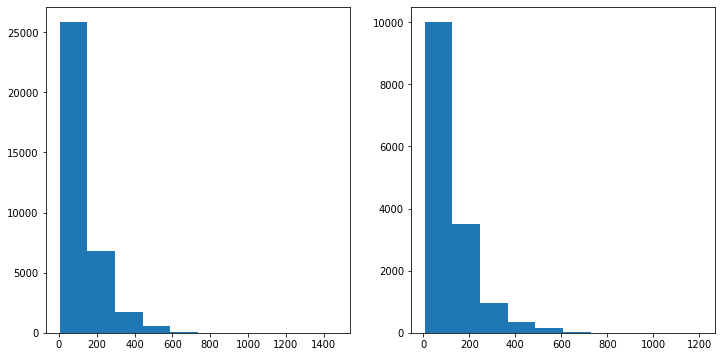

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# Sequence **Normalization**


"""Not all reviews are of same length. To handle this difference in length of 
reviews, we define a maximum length. For reviews which are smaller than this 
length, we pad them with zeros which longer ones are truncated"""

In [16]:
MAX_SEQUENCE_LENGTH = 600

# pad dataset to a maximum review length in words
X_train_1 = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_1 = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train_1.shape, X_test_1.shape

VOCAB_SIZE = len(t.word_index)
VOCAB_SIZE

87543

#Prepare the Model
"""Since textual data is a sequence of words, we utilize 1D convolutions to scan
through the sentences. The model first transforms each word into lower dimensional
 embedding/vector space followed by 1d convolutions and then passing the data 
 through dense layers before the final layer for classification"""

# Embeddings

"""The Embedding layer helps us generate the word embeddings from scratch. This 
layer is also initialized with some weights and is updated based on our optimizer,
 similar to weights on the neuron units in other layers when the network tries
 to minimize the loss in each epoch. Thus, the embedding layer tries to optimize 
 its weights such that we get the best word embeddings that will generate minimum 
 error in the model and capture semantic similarity and relationships among words.
 How do we get the embeddings? Let’s say we have a review with three terms 
 ['movie', 'was', 'good'] and a vocab_map consisting of word to index mappings 
 for 87543 words."""

In [17]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128

# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 600, 300)          26262900  
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 128)          153728    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 300, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 64)           32832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 32)           8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 75, 32)            0

In [18]:
#Model Training
# callbacks
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

In [19]:
# Fit the model
history = model.fit(X_train_1, 
                    y_train, 
                    validation_split=0.1,
                    epochs=10 ,
                    batch_size=BATCH_SIZE,
                    callbacks=[es], 
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 85s 343ms/step - loss: 0.4282 - accuracy: 0.7600 - val_loss: 0.2630 - val_accuracy: 0.8917
Epoch 2/10
247/247 [==============================] - 85s 343ms/step - loss: 0.1440 - accuracy: 0.9483 - val_loss: 0.2698 - val_accuracy: 0.8934
Epoch 3/10
247/247 [==============================] - 85s 344ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 0.5237 - val_accuracy: 0.8643
Epoch 00003: early stopping


In [20]:
# Final evaluation of the model
scores = model.evaluate(X_test_1, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 5s 10ms/step - loss: 0.2471 - accuracy: 0.8992
Accuracy: 89.92%


In [23]:
predictions = model.predict_classes(X_test_1).ravel()
predictions[:10]

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      7490
           1       0.89      0.91      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6626,864
positive,648,6862


In [25]:
# Thanks

In [ ]:
# tokenize train reviews 
tokenized_train = [nltk.word_tokenize(text) for text in X_train]

# tokenize test reviews & encode test labels
tokenized_test = [nltk.word_tokenize(text) for text in X_test]

In [ ]:
#Feature Engineering with word embeddings¶
w2v_num_features = 300
w2v_model = gensim.models.Word2Vec(tokenized_train, 
                                   size=w2v_num_features, 
                                   window=150,
                                   min_count=10, 
                                   workers=4, 
                                   iter=5)   

In [ ]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, 
                                                     model=w2v_model,
                                                     num_features=w2v_num_features)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=w2v_num_features)

print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)


Word2Vec model:> Train features shape: (35000, 300)  Test features shape: (15000, 300)


In [ ]:
#Modeling with deep neural networks
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,)))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(256))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(256))
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(1))
    dnn_model.add(Activation('sigmoid'))

    dnn_model.compile(loss='binary_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model



In [ ]:
w2v_dnn = construct_deepnn_architecture(num_input_features=w2v_num_features)

w2v_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

In [ ]:
batch_size = 100
history = w2v_dnn.fit(avg_wv_train_features, y_train, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
315/315 [==============================] - 3s 10ms/step - loss: 0.3062 - accuracy: 0.8722 - val_loss: 0.2918 - val_accuracy: 0.8726
Epoch 2/10
315/315 [==============================] - 3s 9ms/step - loss: 0.2819 - accuracy: 0.8855 - val_loss: 0.2840 - val_accuracy: 0.8794
Epoch 3/10
315/315 [==============================] - 3s 9ms/step - loss: 0.2739 - accuracy: 0.8870 - val_loss: 0.2917 - val_accuracy: 0.8766
Epoch 4/10
315/315 [==============================] - 3s 9ms/step - loss: 0.2674 - accuracy: 0.8889 - val_loss: 0.2870 - val_accuracy: 0.8803
Epoch 5/10
315/315 [==============================] - 3s 9ms/step - loss: 0.2590 - accuracy: 0.8939 - val_loss: 0.2871 - val_accuracy: 0.8791
Epoch 6/10
315/315 [==============================] - 3s 9ms/step - loss: 0.2503 - accuracy: 0.8966 - val_loss: 0.2863 - val_accuracy: 0.8786
Epoch 7/10
315/315 [==============================] - 3s 9ms/step - loss: 0.2420 - accuracy: 0.9001 - val_loss: 0.2917 - val_accuracy: 0.8757
Epoch

In [ ]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("% Accuracy = ",accuracy_score(y_test, y_pred)*100)

% Accuracy =  88.02666666666667


In [ ]:
print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[6657  833]
 [ 963 6547]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7490
           1       0.89      0.87      0.88      7510

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



In [ ]:
# Thanks